# Beoordeling Tijdreeksmodellen
*Auteurs: O.N. Ebbens (Artesia), D. Brakenhoff (Artesia)*

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. Dit notebook laat zien welke methoden hiervoor gebruikt kunnen worden aan de hand van voorbeelden. De eenvoudigste methode voor de beoordeling van een tijdreeksmodel is een visuele beoordeling. Ook kunnen er diverse statistieken berekend worden voor een geoptimaliseerd tijdreeksmodel. Aan de hand van een stijghoogtereeks uit de praktijk worden deze methodes toegelicht. Voor de berekende statistieken uitgelegd wat de getallen betekenen en hoe deze gebruikt kunnen worden.

Een veelgebruikt criterium voor modelbeoordeling is de ‘fit’, die vaak wordt uitgedrukt met de afkorting EVP, wat staat voor het "Explained Variance Percentage". Hiermee wordt uitgedrukt hoe goed de simulatie op de metingen lijkt. Het notebook laat zien in hoeverre deze ‘fit’ een goede indicatie is voor de voorspellende waarde van het model.

Het notebook behandelt de meest gebruikte statistische toetsen. Speciale aandacht wordt besteed aan het kwantificeren van de betrouwbaarheid van de modelparameters. Welke voorwaarden zijn daarvoor vereist om dit te kunnen doen? Hoe kan je het model aanpassen zodat je aan de vereiste statistische voorwaarden voldoet?

<p style="color:red">%% DB: Ik heb wat tekst aanpassingen gedaan. Introductie kan nog wat duidelijker als de inhoud van het notebook compleet is denk ik. %%</p>

%% 
voorbeelden toevoegen van:
- een model met een hele lange responsefunctie die niet door de geheugentest komt
- Model dat veel beter met toegevoegde invloed en AIC/BIC gaan omlaag
- Model dat beter wordt met toegevoegde invloed maar AIC/BIC gaan omhoog (overgefit)
- Goed model met grote onzekerheid in parameter (plaatje hieronder maken in notebook?)
- Modellen met hoge correlatie tussen 2 parameters (eentje aanpassen en vastzetten dan zien dat de fit goed blijft?)

Nog meer uitleg geven over
- diagnostische toetsen
- waar dubbele procent-tekens staan (%%) moet nog iets gebeuren 

%%

### Inhoudsopgave

- [Maken tijdreeksmodel](#tijdreeksmodel)
- [Visuele beoordeling](#visueel)
- [Validatie](#validatie)
- [Fit statistieken](#fit)
- [Betrouwbaarheid modelparameters](#betrouwbaarheid)
- [Correlatie modelparameters](#correlatie)
- [Geheugen van de responsefunctie](#geheugen)

## Beoordeling

Een tijdreeksmodel kan op een aantal onderdelen beoordeelt worden. In dit notebook komen de volgende onderwerpen aan bod:

- visuele vergelijking gemeten en gemodelleerde tijdreeksen
- validatie tijdreeksmodel met extra metingen 
- fit statistieken
- betrouwbaarheid van parameters (diagnostische toetsen)
- correlatie parameters
- geheugen van de responsfuncties

Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden vastgesteld voor de hierboven genoemde onderdelen. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt

In [9]:
# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
ps.show_versions(numba=True)

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.2
Scipy version: 1.5.2
Pandas version: 1.2.0
Pastas version: 0.16.0
Matplotlib version: 3.3.2
numba version: 0.52.0


In [3]:
# instellingen voor tabelweergave
cmap = plt.get_cmap("RdBu")
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norm(val)))
    return f"background-color: {color}"

def ctxt(val):
    bg = cmap(norm(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

## Maken tijdreeksmodel <a name="tijdreeksmodel"></a>

In dit notebook maken we gebruik van een simpel tijdreeksmodel om de grondwaterstand te simuleren met neerslag en verdamping als verklarende variabelen. 

In [4]:
# inlezen tijdreeksen
oseries = pd.read_csv("data/grondwaterstand.csv",
                      parse_dates=True,  squeeze=True, index_col=0)

neerslag = pd.read_csv("data/neerslag.csv", parse_dates=True,
                       squeeze=True, index_col=0)

verdamping = pd.read_csv("data/verdamping.csv", parse_dates=True,
                         squeeze=True, index_col=0)

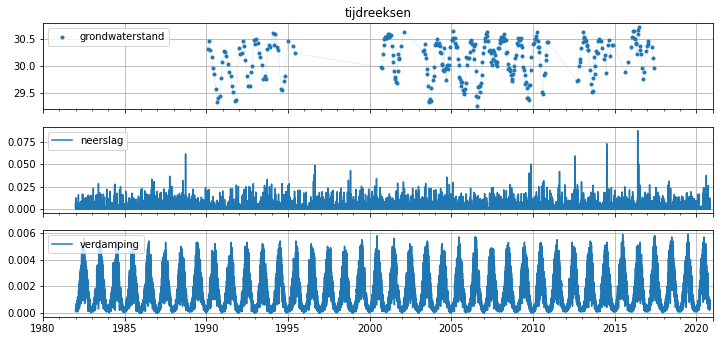

In [5]:
# laat de tijdreeksen zien in een figuur
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(12,6), sharex=True)
oseries.plot(ax=ax1, label='grondwaterstand', marker='.', lw=0.1, legend=True)
neerslag.plot(ax=ax2, label='neerslag')
verdamping.plot(ax=ax3, label='verdamping')
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(dt.datetime(1980,1,1), dt.datetime(2021,1,1))
    ax.legend(loc="upper left")
    ax.grid()
ax1.set_title('tijdreeksen');

In [6]:
# maken tijdreeksmodel
ml = ps.Model(oseries)
sm = ps.StressModel(neerslag-verdamping, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(sm)

In [7]:
ml.solve(report=False)

LinAlgError: SVD did not converge

## Visuele beoordeling <a name="visueel"></a>

De eerste check om de betrouwbaarheid van het model in te schatten is vaak een visuele vergelijking van de modelsimulatie met de metingen. In onderstaande grafiek is deze vergelijking gemaakt. De modelresultaten en de metingen komen behoorlijk goed overeen. Ook is duidelijk dat de verschillen tussen het model en de metingen vooral onstaan bij de extremen, de dalen in de zomer en de pieken in de winter.

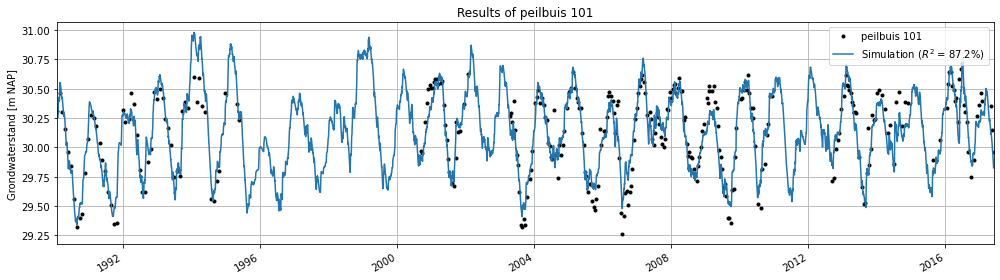

In [11]:
ax = ml.plot(figsize=(14,4))
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.grid()

## Validatie<a name="validatie"></a>

Wanneer er voldoende metingen zijn kan ervoor worden gekozen om een validatie uit te voeren. Hierbij wordt de tijdreeks met gemeten grondwaterstanden gesplitst in een trainingsperiode en een testperiode. Het tijdreeksmodel wordt gefit op de metingen in de trainingsperiode en er wordt een modelsimulatie gemaakt voor de testperiode. Het vergelijken van de gesimuleerde grondwaterstanden met de metingen in de testperiode geeft een goede indicatie hoe goed het model presteert.

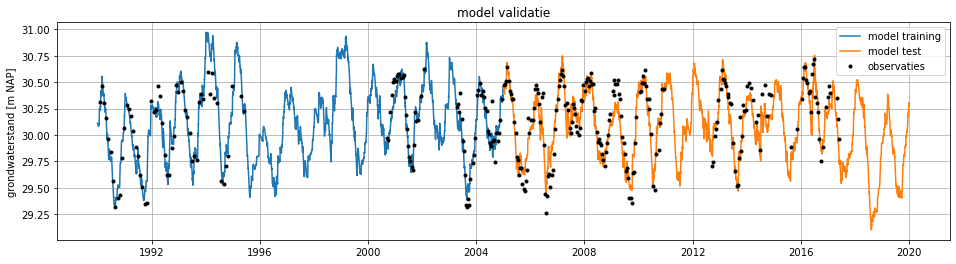

In [39]:
# train het model op periode 1990 - 2005, test het model op de periode 2005 - 2020
ml_train1 = ml.copy()
ml_train1.solve(tmin='1990', tmax='2005', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train1.simulate(tmin='1990', tmax='2005'), label='model training')
ax.plot(ml_train1.simulate(tmin='2005', tmax='2020'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_ylabel('grondwaterstand [m NAP]');

De trainings- en testperiode kunnen zelf worden gekozen. De testperiode kan ook voor de trainingsperiode liggen, zie voorbeeld hieronder. Let er wel op dat er van de verklarende tijdreeksen, in dit geval neerslag en verdamping, metingen beschikbaar moeten zijn voor zowel de test- als de trainingsperiode.

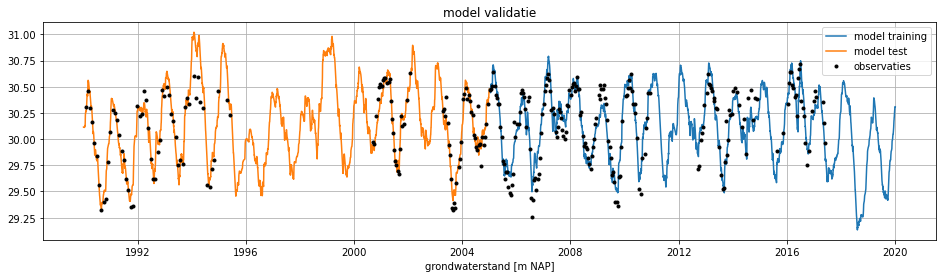

In [40]:
# train het model op periode 2005 - 2020, test het model op de periode 1990 - 2005
ml_train2 = ml.copy()
ml_train2.solve(tmin='2005', tmax='2020', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train2.simulate(tmin='2005', tmax='2020'), label='model training')
ax.plot(ml_train2.simulate(tmin='1990', tmax='2005'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_xlabel('grondwaterstand [m NAP]');

## Fit statistieken<a name="fit"></a>

Naast de visuele vergelijking van gemodelleerde en gemeten grondwaterstanden bestaan er ook verschillende statistieken die iets zeggen over de fit tussen gemodelleerde en gemeten grondwaterstanden. Een aantal veelgebruikte fit statistieken zijn:

- **som van de kwadratische fout / sum of the squares of the error**
<br>
<br>
$\text{SSE} = \sum_{i=1}^{N}(x_i - y_i)^2$
<br>
<br>
- **gemiddelde absolute fout / mean absolute error**
<br>
<br>
$\text{MAE} = \sum_{i=1}^{N}\frac{|x_i - y_i|}{N}$ 
<br>
<br>
- **wortel van de kwadratisch gemiddelde fout / root mean squared error** 
<br>
<br>
$\text{RMSE} = \sqrt{\sum_{i=1}^{N}\frac{ (x_i - y_i)^2}{N}}$
<br>
<br>
- **verklaarde variantie / explained variance percentage**
<br>
<br>
$\text{EVP} = \frac{\sigma_h^2 - \sigma_r^2}{\sigma_h^2} * 100$
<br>
<br>
- **determinatiecoëfficiënt / r-squared**
<br>
<br>
$R^2 = 1-  \frac{N-1}{N-N_{param}}*\frac{\sum_{i=1}^{N}(x_i - y_i)^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$

<br> 
$N$ is het aantal metingen.
<br> 
$N_{param}$ is het aantal vrije parameters.
<br>
$x_i$ en $y_i$ zijn respectievelijk de gemeten en de gemodelleerde grondwaterstand op tijdstip $i$.
<br>
$\sigma_h^2$ en $\sigma_r^2$ zijn respectievelijk de variantie in de gemeten grondwaterstanden en de residuën.
<br>

In [41]:
# fit statistics kunnen in pastas worden opgevraagd met `ml.stats.<naam statische parameter>()`
print(f'Mean absolute error (mae)                         : {ml.stats.mae():.3f}')
print(f'Root mean squared error (rmse)                    : {ml.stats.rmse():.3f}')
print(f'Sum of the squares of the error (sse)             : {ml.stats.sse():.3f}')
print(f'Explained variance percentage (evp)               : {ml.stats.evp():.1f}%')
print(f'R-squared (rsq)                                   : {ml.stats.rsq():.3f}')

Mean absolute error (mae)                         : 0.096
Root mean squared error (rmse)                    : 0.124
Sum of the squares of the error (sse)             : 4.975
Explained variance percentage (evp)               : 87.2%
R-squared (rsq)                                   : 0.872


### voorspellende waarde

Wanneer een model validatie is uitgevoerd kunnen de gesimuleerde en gemeten grondwaterstanden ook worden vergeleken met behulp van dezelfde statistieken. In principe wordt de R-squared enkel gebruikt om de "goodness of fit" te berekenen bij een model kalibratie. Wanneer wordt berekent hoe goed de voorspellingen van het model zijn wordt gebruik gemaakt van de Nash-Sutcliffe model efficiëncy coëfficient. Deze is equivalent aan de R-squared values alleen worden nu niet het aantal vrije modelparameters meegenomen. 

%% Misschien wat onduidelijk het verschil tussen r-squared en NSE, komt hiervandaan https://stats.stackexchange.com/questions/185898/difference-between-nash-sutcliffe-efficiency-and-coefficient-of-determination %%

**Nash-Sutcliffe model efficiency**
<br>
<br>
$NSE = 1-  \frac{\sum_{i=1}^{N}(x_i - y_{i, sim})^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$
<br>
<br>
$y_{i, sim}$ is de met het model voorspelde grondwaterstand.

In [42]:
# de prestatie van het model kan worden berekend met de statistieken in `ps.stats.<naam statische parameter>()`

sim = ml_train1.simulate(tmin='2005', tmax='2020')
obs = ml_train1.oseries.series['2005':'2019']

print('fit statistieken validatie periode 2005 - 2020')
print('----------------------------------------------')
print(f'Mean absolute error (mae)                         : {ps.stats.mae(obs=obs, sim=sim):.3f}')
print(f'Root mean squared error (rmse)                    : {ps.stats.rmse(obs=obs, sim=sim):.3f}')
print(f'Sum of the squares of the error (sse)             : {ps.stats.sse(obs=obs, sim=sim):.3f}')
print(f'Explained variance percentage (evp)               : {ps.stats.evp(obs=obs, sim=sim):.1f}%')
print(f'Nash-Sutcliffe model efficiency coefficient (nse) : {ps.stats.nse(obs=obs, sim=sim):.3f}')

fit statistieken validatie periode 2005 - 2020
----------------------------------------------
Mean absolute error (mae)                         : 0.107
Root mean squared error (rmse)                    : 0.134
Sum of the squares of the error (sse)             : 3.596
Explained variance percentage (evp)               : 85.0%
Nash-Sutcliffe model efficiency coefficient (nse) : 0.844


In [43]:
sim = ml_train2.simulate(tmin='1990', tmax='2005')
obs = ml_train2.oseries.series['1990':'2004']

print('fit statistieken validatie periode 1990 - 2005')
print('----------------------------------------------')
print(f'Mean absolute error (mae)                         : {ps.stats.mae(obs=obs, sim=sim):.3f}')
print(f'Root mean squared error (rmse)                    : {ps.stats.rmse(obs=obs, sim=sim):.3f}')
print(f'Sum of the squares of the error (sse)             : {ps.stats.sse(obs=obs, sim=sim):.3f}')
print(f'Explained variance percentage (evp)               : {ps.stats.evp(obs=obs, sim=sim):.1f}%')
print(f'Nash-Sutcliffe model efficiency coefficient (nse) : {ps.stats.nse(obs=obs, sim=sim):.3f}')

fit statistieken validatie periode 1990 - 2005
----------------------------------------------
Mean absolute error (mae)                         : 0.088
Root mean squared error (rmse)                    : 0.122
Sum of the squares of the error (sse)             : 1.815
Explained variance percentage (evp)               : 88.7%
Nash-Sutcliffe model efficiency coefficient (nse) : 0.881


### overzicht fit parameters

| parameter              | waarde bij optimale fit | minimum  | maximum  |
|------------------------|-------------------------|----------|----------|
| $\text{sse}$           | 0                       | 0        | $\infty$ |
| $\text{mae}$           | 0                       | 0        | $\infty$ |
| $\text{rmse}$          | 0                       | 0        | $\infty$ |
| $\text{evp}$           | 100%                    | 0        | 100      |
| $R^2$                  | 1                       | 0        | 1        |
| $\text{nse}$           | 1                       | $-\infty$| 1        |

### Overfitting

<p style="color:red">%% DB: wel een hele kleine verbetering van EVP, kunnen we geen beter voorbeeld vinden? %%</p>

Wanneer er meer verklarende variabelen, en bijbehorende modelparameters, aan een tijdreeksmodel worden toegevoegd verbetert over het algemeen de fit. Zelfs wanneer de grondwaterstanden niet wordt beïnvloed door de verklarende variabele. Immers, hoe meer vrijheidsgraden (parameters) het model heeft des te makkelijker het model op de metingen kan worden gefit. Wanneer zo'n verklarende variabele wordt toegevoegd verbetert de voorspellende waarde van het model niet. Het fenomeen waarbij meer parameters worden toegevoegd aan het model dan kan worden gerechtvaardigt op basis van de metingen heet overfitting. 

Het is dus niet mogelijk om op basis van enkel de fit statistieken aan te geven of het model verbetert na het toevoegen van een verklarende variabele. Twee statistieken die wel rekening houden met overfitting zijn:

- **aic**: Akaike information criterion
- **bic**: Bayesian information criterion

Zowel de `aic` als de `bic` zijn een maat voor de relatieve hoeveelheid informatie die verloren is gegaan in het model. Het zijn dus relatieve waarde en kunnen het best gebruikt worden om verschillende modellen van dezelfde meetreeks met elkaar te vergelijken. Wanneer de `aic` en `bic` lager worden na het toevoegen van een verklarende variabele betekent dit dat het model verbetert (er gaat relatief minder informatie verloren). Als de aic en bic hoger worden dan heeft het toevoegen van de parameters niet bijgedragen aan een verbetering van het model.

In het voorbeeld hieronder is de `evp`, `aic` en `bic` van een model zonder en met een staptrend getoond. Door het toevoegen van de staptrend is de `evp` van het model toegenomen met 0.36%. De aic en de bic zijn ook toegenomen. Dit betekent dat de fit van het model weliswaar is verbeterd maar de voorspellende waarde %%IS DIT ZO??%% is verslechterd.

In [44]:
# evp, aic en bic huidig model
print(f'Explained variance percentage (evp)  : {ml.stats.evp():.2f}%')
print(f'R-squared (rsq)                      : {ml.stats.rsq():.2f}')
print(f'Akaike information criterion (aic)   : {ml.stats.aic():.2f}')
print(f'Bayesian information criterion (bic) : {ml.stats.bic():.2f}')


Explained variance percentage (evp)  : 87.18%
R-squared (rsq)                      : 0.87
Akaike information criterion (aic)   : 6.79
Bayesian information criterion (bic) : 25.68


In [45]:
# voeg een steptrend toe aan het model
ml_step = ml.copy()
sm = ps.stressmodels.StepModel("2007", "step", rfunc=ps.One)
ml_step.add_stressmodel(sm)
ml_step.solve(tmin='1990', report=False)

In [46]:
# evp, aic en bic model met steptrend
print(f'Explained variance percentage  : {ml_step.stats.evp():.2f}%')
print(f'R-squared (rsq)                : {ml_step.stats.rsq():.2f}')
print(f'Akaike information criterion   : {ml_step.stats.aic():.2f}')
print(f'Bayesian information criterion : {ml_step.stats.bic():.2f}')

Explained variance percentage  : 87.54%
R-squared (rsq)                : 0.88
Akaike information criterion   : 10.85
Bayesian information criterion : 37.29


In [47]:
# in pastas kan je een overzicht krijgen van alle fit statistieken
ml.stats.summary()

,Value
Statistic,
rmse,0.124261
rmsn,0.094257
sse,4.975068
mae,0.096235
nse,0.871814
evp,87.182783
rsq,0.871847
bic,25.679383
aic,6.791122


## Betrouwbaarheid modelparameters<a name="betrouwbaarheid"></a>

Naast de beoordeling van de model fit is het ook van belang om te kijken naar de modelparameters. Externe invloeden worden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten. Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een noisemodel worden toegevoegd. In het voorbeeld hieronder zijn de parameters weergegeven van een tijdreeksmodel met recharge en een staptrend als externe invloeden. 

In [48]:
# voorbeeld parameters van model met recharge en step trend 
ml_step.parameters[['initial', 'optimal', 'pmin', 'pmax', 'stderr']]

,initial,optimal,pmin,pmax,stderr
recharge_A,210.475594,472.754740,0.00001,21047.559369,34.935570
recharge_n,1.000000,1.102530,0.10000,100.000000,0.038636
recharge_a,10.000000,100.590483,0.01000,10000.000000,11.382372
step_d,1.000000,0.053916,0,NaN,0.027539
step_tstart,732677.000000,732677.000000,612411,825914.000000,NaN
constant_d,30.124737,29.868226,NaN,NaN,0.024003
noise_alpha,17.000000,42.683869,0.00001,5000,6.424809


Per parameters zijn de volgende waarden weergegeven:
- **initial**: de initiële waarde
- **optimal**: de geoptimaliseerde waarde
- **pmin en pmax**: de bandbreedte waarbinnen de parameters worden geoptimaliseerd
- **stderr**: de standaarddeviatie van de geoptimaliseerde parameter

De berekende standaarddeviaties zijn alleen betrouwbaar als aan een aantal voorwaarden wordt voldaan. Deze voorwaarden zijn hieronder uitgewerkt. Daaronder wordt behandeld hoe je de standaarddeviatie kan gebruiken om meer inzicht te krijgen in de modelresultaten.

### Model diagnostics

Wanneer het ruismodel de respons is van een witte ruis proces is de standaarddeviatie van de parameters betrouwbaar. Dit is het geval wanneer er geen significante autocorrelatie in de residuën aanwezig is, geen heteroscedasticiteit in de ruis en de ruis die voldoet aan een, bij voorkeur normale, statistische verdeling.

Er zijn verschillende tests beschikbaar om deze voorwaarden te checken. Met de **Shapiro** en **D'Agostino** tests kan worden gekeken of de noise normaal verdeeld is. De **Runs** test wordt gebruikt om te kijken of er significante autocorrelatie in de residuën aanwezig is. Naat de **Runs** test kan ook nog gekeken worden naar de **Ljung-Box** en **Durban-Watson** tests bij een model met een vaste meetfrequentie en de **Stoffer-Toloi** test voor een model met een variabele meetfrequentie.

%% 
Nog wat vragen:
- is het nuttig om iedere test nog in detail te beschrijven?
- waarom twee testen voor normale verdeling en autocorelatie? Wat als de ene wel door de test komt en de ander niet?
- wat is heteroscedasticiteit? Moet hier nog een test voor komen?
- Klopt het dat de standaarddeviatie betrouwbaar is bij witte ruis? Of zijn er nog meer voorwaarden?
- Klopt het dat dit alle voorwaarden zijn voor witte ruis?
%%

In [49]:
# diagnostische toetsen voor het model met steptrend
ml_step.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.95,0.00,True
D'Agostino,Normality,32.75,0.00,True
Runs test,Autocorr.,-3.29,0.00,True
Stoffer-Toloi,Autocorr.,16.39,0.29,False


c:\users\oebbe\02_python\pastas\pastas\stats\tests.py:616: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")


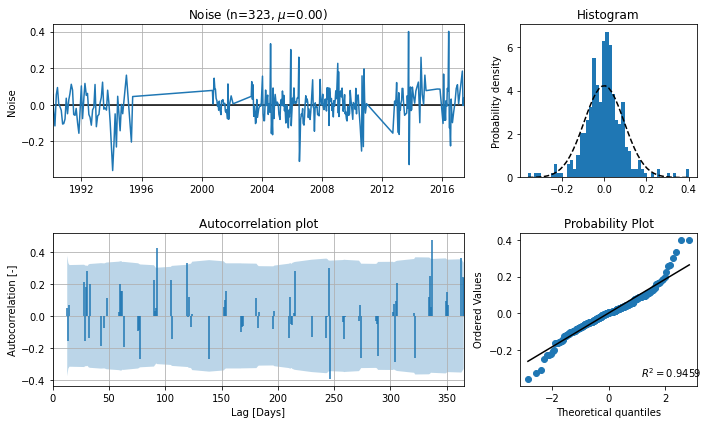

In [50]:
# visualisatie diagnostische toetsen
ml.plots.diagnostics(acf_options={"max_gap": 60, "min_obs": 24});

### Standaardeviatie parameters

Wanneer wordt voldaan aan bovengenoemde voorwaarden kan de standaarddeviatie van de modelparameters worden gebruikt om de betrouwbaarheid van het model in te schatten. Een eenvoudige check om de betrouwbaarheid van een model te toetsen is om te kijken naar de grootte van de standaarddeviatie t.o.v. de geoptimaliseerde parameterwaarde. Hieronder testen we met het voorbeeldmodel of de absolute, geoptimaliseerde parameterwaarde groter is dan 2x de standaarddeviatie.

In [51]:
# check of de waarde van de parameter groter is dan 2x de standaarddeviatie
parameters = ml_step.parameters[ml_step.parameters.vary]
parameters['optimal'].abs() > (parameters['stderr']*2)

recharge_A      True
recharge_n      True
recharge_a      True
step_d         False
constant_d      True
noise_alpha     True
dtype: bool

In het voorbeeldmodel komen alle parameters behalve de `step_d` parameter door onze test. Dit betekent dat de `step_d` parameter een grote onzekerheid kent. De standaarddeviatie van de modelparameters kan worden gebruikt om een bandbreedte te bepalen bij een modelsimulatie. %%HOE KAN DIT IN PASTAS?%%

%% ik bedoelde eigenlijk een modelsimulatie met bandbreedte op basis van de standaarddeviatie van de parameters.%%

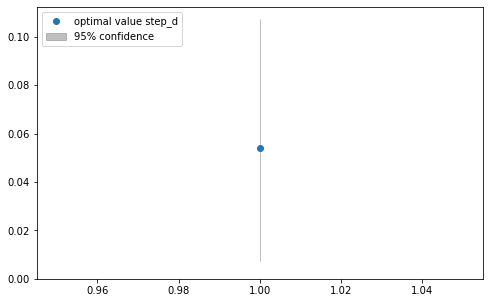

In [52]:
# code om de bandbreedte weer te geven o.b.v. de standaarddeviatie.
ci_step = ml_step.fit.ci_step_response("step", n=1000, alpha=0.05)

step = ml_step.get_step_response("step", add_0=True)
step_d = ml_step.get_parameters("step")[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(1, step_d, marker="o", ls="none", label="optimal value step_d")

# %% in dit geval is fill_between niet zo logisch, maar voor evt andere step responses wel

ax.fill_between(ci_step.index, ci_step.iloc[:, 0], ci_step.iloc[:, 1], color="gray",
                zorder=-1, alpha=0.5, label="95% confidence")
ax.legend(loc="upper left")
ax.set_ylim(bottom=0.0);

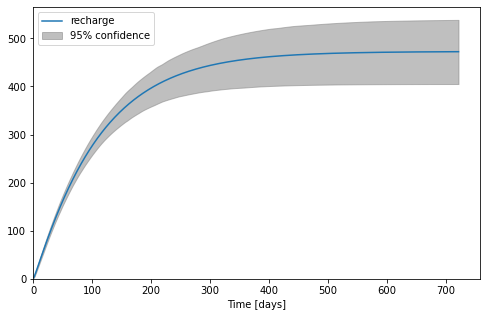

In [53]:
# code om de bandbreedte weer te geven o.b.v. de standaarddeviatie.
ci_step = ml_step.fit.ci_step_response("recharge", n=1000, alpha=0.05)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ml_step.plots.step_response(['recharge'], ax=ax)

ax.fill_between(ci_step.index, ci_step.iloc[:, 0], ci_step.iloc[:, 1], color="gray",
                zorder=-1, alpha=0.5, label="95% confidence")
ax.legend(loc="upper left")
ax.set_ylim(bottom=0.0);

## Parameter correlaties<a name="correlatie"></a>

Ook is het van belang om te kijken naar de parameter correlaties. Wanneer twee modelparameters sterk gecorreleerd zijn betekent dit dat bijna dezelfde modelresultaten kunnen worden verkregen met andere waardes van deze twee parameters. Hieronder is de correlatiematrix weergegeven van de parameters in het voorbeeldmodel.

In [54]:
# correlatiecoëfficiënten (rho)
ml_step.fit.pcor.style.applymap(cbg).applymap(ctxt).set_precision(2)

,recharge_A,recharge_n,recharge_a,step_d,constant_d,noise_alpha
recharge_A,1.00,-0.47,0.83,-0.13,-0.64,0.01
recharge_n,-0.47,1.00,-0.80,0.05,0.30,-0.01
recharge_a,0.83,-0.80,1.00,-0.10,-0.54,-0.00
step_d,-0.13,0.05,-0.10,1.00,-0.41,0.02
constant_d,-0.64,0.30,-0.54,-0.41,1.00,-0.00
noise_alpha,0.01,-0.01,-0.00,0.02,-0.00,1.00


Uit de parameter correlaties van het model volgt dat de recharge parameters `A,n & a` en de constante `constant_d` een absolute correlatiecoëfficient groter dan 0.5 hebben. Dit betekent dat met een andere set aan parameter waarden redelijk vergelijkbare resultaten kunnen worden verkregen. In dit geval wordt de grondwaterstand berekend als de som van de bijdrage van de recharge en de constante. Een lagere constante kan relatief eenvoudig gecorrigeerd worden door een grotere bijdrage van de recharge. In dit geval is de grote correlatie dan ook niet erg problematisch voor de bruikbaarheid van het model. Grote parameter correlaties kunnen wel problematisch zijn wanneer je de bijdragen van verschillen verklarende variabelen los van elkaar wilt bekijken terwijl de parameters van de verklarende variabelen sterk gecorreleerd zijn. Een voorbeeld hiervan wordt hieronder uitgewerkt. 

**voorbeeld problematische parameter correlaties**<br>
Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruibkaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.

%%VOORBEELD NOG UITWERKEN%%

In [55]:
# eventueel voorbeeld uitwerken wanneer correlatie een probleem is


## Geheugen<a name="geheugen"></a>

%%RESPONSEFUNCTIE ERUIT OM HET MINDERS PASTAS SPECIFIEK TE MAKEN%%

<p style="color:red">DB: leuk om hier ook een voorbeeldje te zien met (te) lange respons?</p>

Een tijdreeksmodel is opgebouwd uit één of meerdere externe invloeden. In pastas worden deze invloeden gemodelleerd door middel van een responsfunctie. De responsfunctie geeft aan hoe een eenheidsimpuls van een stress (externe invloed) wordt omgezet naar een verandering in de grondwaterstand. Deze responsfunctie bevat informatie over hoe lang het duurt voordat een verandering in een externe invloed niet meer terug te zien is als een verandering in de grondwaterstand. In het geval van recharge kan je dit zien als de tijd die het duurt voordat de grondwaterstand weer op het oude niveau is na een regenbui. Deze tijd wordt ook wel het geheugen van een externe invloed genoemd.

Het geheugen van de verschillende invloeden is van belang bij het beoordelen van het tijdreeksmodel. Het gaat hierbij met name om de verhouding tussen de lengte (tijdsduur) van het tijdreeksmodel en het geheugen van de verschillende invloeden. Stel het tijdreeksmodel beslaat een periode van 1 jaar en het geheugen van de neerslagrespons is 2 jaar. Dan is het effect van neerslag op dag 1 van het tijdreeksmodel nog niet uitgewerkt op de laatste dag van het tijdreeksmodel. Dit maakt het erg lastig om de invloed van de neerslag goed te schatten. Vaak wordt daarom als eis aangehouden dat de lengte van de tijdreeks groter moet zijn dan 2x het geheugen van een externe invloed. 

Hieronder zijn de block response en de modelresultaten in één figuur geplot. Hieruit volgt dat de lengte van het tijdreeksmodel een aantal maal groter is dan het geheugen van de responsefunctie van de recharge.

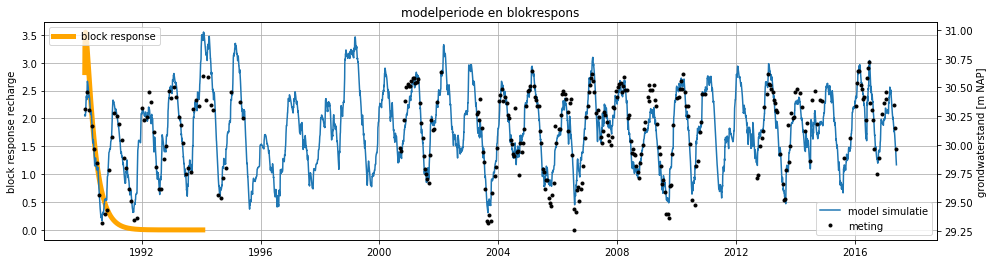

In [56]:
# get response function
sm = ml.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16,4))
block_resp = resp_func.block(ml.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=5)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml.simulate(), label='model simulatie')#, lw=0.2)
ax2.plot(oseries['1990':], marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=4)

Het bepalen van het geheugen van de responsfunctie is niet altijd even vanzelfsprekend. Regelmatig worden exponentiële responsefuncties gebruikt met een horizontale asymptoot op y=0, de respons zal dus nooit gelijk zijn aan 0. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de respons 0 is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

geheugen (t95) -> 327 dagen


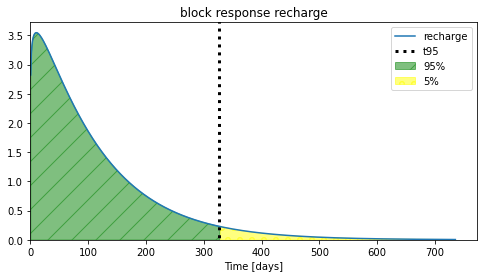

In [57]:
t95 = resp_func.get_tmax(ml.get_parameters('recharge'), cutoff=0.95)
print(f'geheugen (t95) -> {t95:.0f} dagen')

ax = ml.plots.block_response(figsize=(8,4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=3)

block_response = sm.rfunc.block(ml.get_parameters('recharge'))

ax.fill_between(range(1,len(block_response)+1), 0, block_response, 
                where=range(len(block_response)) < t95, hatch='/',
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1,len(block_response)+1), 0, block_response, 
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('block response recharge');

## Fit report pastas<a name="fitreport"></a>

<p style="color:red">%% DB: Pastas specifiek weer...? </p> 

Een groot deel van de hierboven besproken tools voor het beoordelen van een model worden in pastas automatisch getoond na het optimaliseren van een tijdreeksmodel met `ml.solve()`. Dit zogenaamde fit rapport geeft een overzicht van de resultaten van de optimalisatie. Het rapport bestaat uit 4 onderdelen:
- Algemene modelinstellingen (linksboven)
- Fit statistieken (rechtsboven)
- Parameters (midden)
- Parameter correlaties (onder)

Hieronder is een fit rapport weergegeven, daaronder is per onderdeel aangegeven welke resultaten worden getoond.

In [58]:
ml.solve(tmin='1990')

Fit report peilbuis 101          Fit Statistics
nfev     20                     EVP          87.18
nobs     323                    R2            0.87
noise    True                   RMSE          0.12
tmin     1990-01-30 00:00:00    AIC           6.79
tmax     2017-05-30 00:00:00    BIC          25.68
freq     D                      Obj           1.43
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   480.819216   ±7.59%  210.475594  True
recharge_n     1.098409   ±3.48%    1.000000  True
recharge_a   102.749876  ±11.53%   10.000000  True
constant_d    29.888102   ±0.08%   30.124737  True
noise_alpha   45.193179  ±15.23%   17.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.83
           constant_d -0.77
recharge_n recharge_a -0.79
recharge_a constant_d -0.64


**Algemene modelinstellingen**<br>
Hier worden een aantal instellingen en resultaten genoemd van het model. Dit zijn:
- `nfev`: Het aantal model simulaties dat is uitgevoerd door het optimalisatie-algoritme voordat de optimale parameters zijn gevonden. Wanneer de optimale oplossing niet gevonden kan worden en het maximaal aantal functie-evaluaties is berijkt wordt een waarschuwing gegeven.
- `nobs`: Het aantal metingen dat is gebruikt om de model simulatie te fitten op de metingen. In ons geval is dat het aantal metingen in `oseries1`.
- `noise`: parameters om aan te geven of het noise model is gebruikt bij de optimalisatie. Meer informatie over het noisemodel is hier te vinden %%REFERENTIE%%
- `tmin` and `tmax`: de start en de eindtijd van de metingen die gebruikt worden om het model te optimaliseren. Deze kunnen worden opgegeven in de `ml.solve()` functie. Standaard wordt de start- en eindtijd van de `oseries` gebruikt. In dit geval is aangegeven dat als starttijd 1 januari 1990 gebruikt moet worden.
- `freq`: de frequentie van het tijdreeksmodel. Standaard wordt een dagelijkse frequentie gebruikt %%KLOPT DIT????%%. Dit betekent dat de gesimuleerde en gemeten waarde op dagbasis worden vergeleken indien er metingen beschikbaar zijn op een dag.
- `warmup`: De inlooptijd van het model. De grondwaterstanden op een bepaalde dag hangen af van de externe invloeden (stresses) over een bepaalde periode voor deze dag. We weten de lengte van deze periode niet. Standaard wordt een inlooptijd van 10 jaar min de starttijd `tmin` van het model gebruikt.
- `solver`: Het optimalisatie-algoritme dat wordt gebruikt om de gesimuleerde grondwaterstanden te fitten op de gemeten grondwaterstanden. Met de standaard instellingen wordt gebruikt gemaakt van de [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) solver uit de `scipy` package.

**Fit statistics**<br>
Rechtsboven in het model rapport
Deze statistieken geven informatie over de fit tussen gesimuleerde en gemeten grondwaterstanden. De volgende fit parameters worden getoond: 
- `EVP`: Explained variance ook wel bekend als de Nash Sutcliffe coëfficiënt. Een waarde van 100% betekent dat de gemodelleerde en gesimuleerde grondwaterstanden volledige overeenkomen. In de praktijk komt dat niet voor. Meestal wordt een fit hoger dan 60-80% acceptabel geacht om de modelresultaten verder te gebruiken.
- `R2`: the $R^2$ waarde wordt ook wel de determinatiecoëfficiënt genoemd. Een waarde van 1 staat voor een optimale fit.
- `RMSE`: de root mean squared error. Een waarde van 0 staat voor een optimale fit. 
- `AIC`: the Aikake Information Criterion.
- `BIC`: the Bayesan Information Criterion. 

**Parameters**<br>
Dit deel geeft de parameter waarde weer die zijn gevonden met het optimalisatie algoritme. Behalve de optimale waarde wordt ook de standaard deviatie en de initiële waarde weergegeven. In de laatste kolom is aangegeven of de parameter wel `vary=True` of niet `vary=False` is meegenomen in de optimalisatie.

**Parameter correlations**<br>
Deze sectie geeft de correlaties tussen de parameters aan. Alleen de correlaties met een absolute waarde hoger dan 0.5 zijn weergegeven. Wanneer twee parameters een correlatie van 1 of -1 hebben betekent dit dat vergelijkbare modelresultaten bereikt kunnen worden met een verschillende set van de twee parameters.